In [53]:
import scipy
import math
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn
import torch
from torch.optim import Adam
from torch.nn.functional import tanh, one_hot, relu
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder, LabelEncoder
from sklearn.datasets import fetch_openml

In [10]:
use_mnist = False

if(use_mnist):
    mnist = fetch_openml('mnist_784')
    X, y = mnist.data.to_numpy(), mnist.target.to_numpy()
    X = X/256
else:
    digits = sklearn.datasets.load_digits()
    X, y = digits.data, digits.target
    X = X/16
    
x_train, x_test,y_train, y_test = sklearn.model_selection.train_test_split(X, y, 
                                        test_size = .1, random_state = 47)

In [42]:
modified = False

peekX = 10
peekY = 10

# Dimensions of each image
datx = int(math.sqrt(np.shape(X[0])[0]))
daty = int(math.sqrt(np.shape(X[0])[0]))

#Number of weights
dim = 200
dim = max(dim, peekX*peekY)



#Input and output dimensions
idim = np.shape(X[0])[0]
odim = 10

#Other model parameters
p = 3
k = 3
delta = .4
n = 4.5
m = 2
R=1

#Training parameters
train_size = np.shape(x_train)[0]
test_size = np.shape(x_test)[0]
Nepochs = 500
batch_size = 100
epsmax = .04

<Figure size 432x288 with 0 Axes>

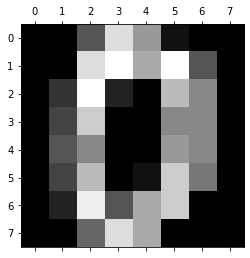

In [43]:
def look(X):
    plt.gray()
    plt.matshow(np.asmatrix(np.reshape(X, (datx,daty))))
    plt.show()
look(X[0])

In [44]:
def peek_weights(datx, daty, peekX, peekY, weights):
    fig=plt.figure(figsize=(12.9,10))
    fulmat = np.zeros((datx*peekX,daty*peekY))
    for i in range(peekX):
        for j in range(peekY):
            fulmat[i*datx:i*datx+datx,j*daty:j*daty+daty] = np.reshape(weights[peekY*i+j], (datx,daty))
    im = plt.imshow(fulmat, cmap = 'bwr')
    fig.colorbar(im,ticks=[np.amin(fulmat), 0, np.amax(fulmat)])
    plt.axis('off')
    return

def vec_prod(x, w, p):
    return np.dot(np.sign(w)*np.absolute(w)**(p-1), np.transpose(x))

In [45]:
def unsuperv_fast(x_train, y_train):
    #initialize weights
    weights = np.random.normal(0, 1, (dim, idim))
    for epochs in range(Nepochs):
        eps = epsmax*(1-epochs/Nepochs)
        x_train, y_train = sklearn.utils.shuffle(x_train, y_train)
        for i in range (train_size//batch_size):
            x_batch = x_train[batch_size*i:batch_size*(i+1),:]
            
            #Fast implementation
            inp_lay = vec_prod(x_batch, weights, p)
                   
            argkey = np.argsort(inp_lay, axis = 0)#Should this be 1?
            gfunc = np.zeros((dim, batch_size))
            
            gfunc[argkey[dim-1,:], np.arange(batch_size)]=1
            if(modified):
                for i in range(k-1):
                    argkey[dim-1-i]
            gfunc[argkey[dim-k-1,:], np.arange(batch_size)]= -1*delta
            
            gim = np.sum(np.multiply(gfunc,inp_lay), axis = 1)
            v = R**p*np.dot(gfunc, x_batch)-np.multiply(np.outer(gim, np.ones(idim)), weights)
            
            trans = sklearn.preprocessing.MaxAbsScaler()
            trans.fit(v)
            weights += eps*trans.transform(v)
            
    return weights

In [46]:
def loss_fn():
    return np.sum(np.absolute(y_tr-finlay)**m)

# TODO: finish supervised learning algorithm
def learn_final_layer(weights):
    finlay = np.random.normal((dim, odim))
    for epochs in range(Nepochs):
    
        onehot = sklearn.preprocessing.OneHotEncoder()
        y_tr = onehot.fit_transform(y_train.reshape(-1,1))

dim x: (1617, 64)
dim y: (1617,)


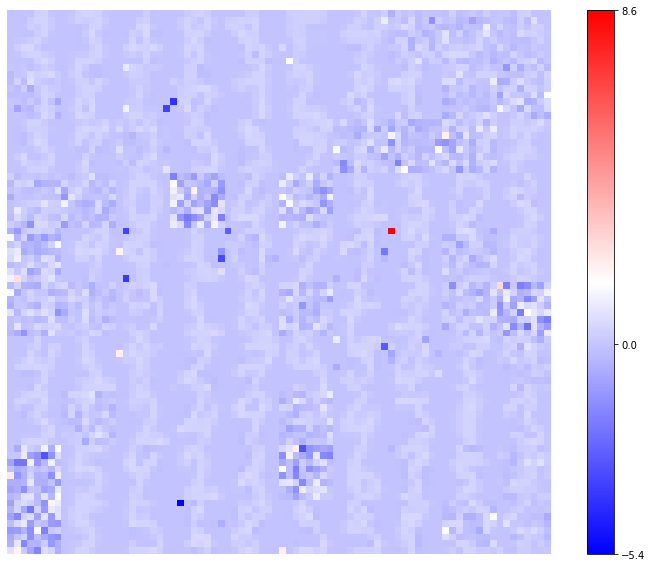

In [47]:
print(f"dim x: {np.shape(x_train)}")
print(f"dim y: {np.shape(y_train)}")
weights = unsuperv_fast(x_train, y_train)
peek_weights(datx, daty, peekX, peekY, weights)

In [26]:
print(torch.from_numpy(weights).size())
print(torch.from_numpy(x_train).size())
print(torch.from_numpy(y_train).size())

torch.Size([200, 64])
torch.Size([1617, 64])
torch.Size([1617])


Update: I think the unsupervised code is working now, but I think it might be either a hyperparamter tuning, dataset, or other issue that the digits are only sometimes visible in the weights, and often only faintly so. 

I'm thinking once we have hyperparameters tuned and everything we can finsh the learning the final layer code, and maybe tru to learn multiple layers biologically inspired. Idk how much we should do... also I guess we can do some standard backprop trained neural net too. Not sure if there's anything else to do that seems like a lot as is.

Some of the things that we still have to do in the supervised learning part:

    - implement adjustable learning rates

In [71]:
def loss_torch(out, target):
    loss = torch.sum(torch.pow(torch.abs(out - target), m))
    return loss

In [82]:
def learn_final():
    # transform data from numpy to torch
    x_tr_torch = torch.from_numpy(x_train)
    y_tr_torch = torch.from_numpy(y_train)
    x_test_torch = torch.from_numpy(x_test)
    y_test_torch = torch.from_numpy(y_test)
    
    # one-hot encoding of the output
    target = one_hot(y_tr_torch)
    
    # Initialize final layer
    finlay = torch.randn(dim,odim, dtype = torch.double)
    finlay.requires_grad_()
    
    # transform final layer to torch
    midlay = torch.from_numpy(weights)
    
    # start adam optimizer
    optimizer = Adam([finlay], lr = 0.001)
    
    # keep track of loss and test error rate
    loss_hist = list()
    error_rate = list()
    
    
    # iterate over epochs and batches
    for epochs in range(Nepochs):
        epoch_loss = list()
        for i in range (train_size//batch_size):
            
            # set gradients to zero
            optimizer.zero_grad()
            
            # select batch
            x_batch      = x_tr_torch[batch_size*i:batch_size*(i+1),:]
            target_batch = target[batch_size*i:batch_size*(i+1),:]
            
            # perform the matrix multiplication XW
            # have to transpose to match dimensions
            # Use relu and then take power
            h = torch.pow(relu(torch.matmul(x_batch, torch.transpose(midlay, 0, 1))), n)
    
            # perform tanh(Hy) operation
            y_pred = tanh(torch.matmul(h, finlay))
            
            # compute loss
            loss = loss_torch(y_pred, target_batch)
            
            # add loss to epoch loss
            epoch_loss.append(loss.item())
            
            # backward pass
            loss.backward()
            
            # update weights
            optimizer.step()
            
        # append loss to loss history    
        loss_hist.append(sum(epoch_loss))
        
        # compute train set error
        with torch.no_grad():
            # do a forward pass
            h = torch.pow(relu(torch.matmul(x_test_torch, torch.transpose(midlay, 0, 1))), n)
            y = tanh(torch.matmul(h, finlay))
            y_pred = torch.argmax(y, dim=1)
            
            # append test error rate
            correct = torch.sum((y_pred == y_test_torch).float())
            error_rate.append(correct.item() / len(y_test))
            
    return finlay, loss_hist, error_rate
    
    

In [84]:
finlay, loss_hist, error_hist = learn_final()

int